In [1]:

# conda create --name torch_env python=3.9
# conda activate torch_env

# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=torch_env

# conda install -c "nvidia/label/cuda-11.6.0" cuda-toolkit
# pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

# python -c "import torch; print(torch.version.cuda)"

# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-geometric
# pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.1+cu116.html

# pip install pyyaml tomli matplotlib sympy ipywidgets


In [2]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:

1. ~~spherical emission~~
2. adaptive timestepping
3. ~~divergence solver~~
4. ~~xsph viscosity~~
5. monaghan viscosity
6. ~~setup dambreak~~
7. setup dambreak with obstacle
8. setup flow past cylinder
9. add wcsph (müller)
10. add compressible sph
11. setup shockwave scenario for compressible sph
12. ~~density solver warm start~~
13. ~~particle shifting~~
14. shifting needs thresholding for free surfaces!! (delta+ sph paper shifting idea based on renormalization vector??)
15. ~~velocityBC~~
16. device integrals for sdf based renormalization matrix
17. ~~rewrite MLS interpolation for stability based on delta+ sph~~
18. improve MLS performance
19. improve overall performance

In [4]:
from src.simulationBase import SPHSimulation
from src.kernels import kernel, kernelGradient, wendland, wendlandGrad, cohesionKernel, getKernelFunctions
from src.util import *
from src.module import Module
from src.parameter import Parameter

In [5]:
# import modules to build simulation with
from src.modules.density import densityModule
from src.modules.neighborSearch import neighborSearchModule
from src.modules.akinciTension import akinciTensionModule
from src.modules.solidBC import solidBCModule, sdPolyDerAndIntegral
from src.modules.periodicBC import periodicBCModule
from src.modules.velocityBC import velocityBCModule
from src.modules.implicitShifting import implicitIterativeShiftModule
from src.modules.gravity import gravityModule
from src.modules.xsph import xsphModule
from src.modules.dfsph import dfsphModule
from src.modules.adaptiveDT import adaptiveTimeSteppingModule

In [6]:
# fig, axis = plt.subplots(2,2, figsize=(9 *  1.09, 9), squeeze = False)
# for axx in axis:
#     for ax in axx:
#         ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
#         ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axis('equal')
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

# positions = state['fluidPosition'].detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data = polyDer[:,0].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = polyGrad[:,0].detach().cpu().numpy(), s = 4)
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

In [7]:
class dfsphSimulation(SPHSimulation):    
    def __init__(self, config = tomli.loads('')):
        super().__init__(config)
        
        self.modules = []
        self.moduleParameters = []
        
        print('Processing modules')
        self.neighborSearch = neighborSearchModule()
        self.sphDensity = densityModule()
        self.periodicBC = periodicBCModule()
        self.solidBC = solidBCModule()
        self.DFSPH = dfsphModule()
        self.XSPH = xsphModule()
        self.velocityBC = velocityBCModule()
#         self.shiftModule = implicitIterativeShiftModule()
        self.gravityModule = gravityModule()
        self.adaptiveDT = adaptiveTimeSteppingModule()
        self.surfaceTension = akinciTensionModule()
        
        self.modules.append(self.neighborSearch)
        self.modules.append(self.sphDensity)
        self.modules.append(self.periodicBC)
        self.modules.append(self.solidBC)
        self.modules.append(self.velocityBC)
        self.modules.append(self.DFSPH)
        self.modules.append(self.XSPH)
#         self.modules.append(self.shiftModule)
        self.modules.append(self.gravityModule)
        self.modules.append(self.adaptiveDT)
        self.modules.append(self.surfaceTension)        
        
        print('Processing module parameters')
        for module in self.modules:    
            moduleParams =  module.getParameters()
            if moduleParams is not None:
                for param in moduleParams:
                    param.parseConfig(self.config)
                self.moduleParameters = self.moduleParameters + moduleParams
                
    def initializeSimulation(self):
        super().initializeSimulation()
        
        
    def timestep(self):
        self.periodicBC.enforcePeriodicBC(self.simulationState, self)
        
        self.simulationState['fluidNeighbors'], self.simulationState['fluidDistances'], self.simulationState['fluidRadialDistances'] = \
            self.neighborSearch.search(self.simulationState, self)
        
        self.solidBC.filterFluidNeighborhoods(self.simulationState, self)
        
        self.simulationState['fluidToGhostNeighbors'], self.simulationState['ghostToFluidNeighbors'], self.simulationState['ghostParticleBodyAssociation'], \
            self.simulationState['ghostParticlePosition'], self.simulationState['ghostParticleDistance'], self.simulationState['ghostParticleGradient'], \
            self.simulationState['ghostParticleKernelIntegral'], self.simulationState['ghostParticleGradientIntegral'] = self.solidBC.search(self.simulationState, self)
        
        
        self.simulationState['fluidDensity'] = self.sphDensity.evaluate(self.simulationState, self)
        self.simulationState['boundaryDensity'], self.simulationState['boundaryGradient'] = self.solidBC.density(self.simulationState, self)
        self.simulationState['fluidDensity']  += self.simulationState['boundaryDensity']
        self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
            
        self.simulationState['fluidAcceleration'][:] = 0. 
        self.simulationState['fluidAcceleration'] += self.gravityModule.evaluate(self.simulationState, self)
        
        #-9.81 * self.simulationState['fluidPosition'] / torch.linalg.norm(self.simulationState['fluidPosition'],axis=1)[:,None]
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        if self.config['dfsph']['divergenceSolver']:
            self.simulationState['densityIterations'] = self.DFSPH.divergenceSolver(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
            
        sphSimulation.simulationState['fluidNormals'] = self.surfaceTension.computeNormals(sphSimulation.simulationState, sphSimulation)
        self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
        sphSimulation.simulationState['fluidCohesionForce'] = self.surfaceTension.cohesionForce(sphSimulation.simulationState, sphSimulation)
        sphSimulation.simulationState['fluidCurvatureForce'] = self.surfaceTension.curvatureForce(sphSimulation.simulationState, sphSimulation)
        self.simulationState['fluidAcceleration'] += self.simulationState['fluidCohesionForce']
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        self.simulationState['densityIterations'] = self.DFSPH.incompressibleSolver(self.simulationState, self)
        self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)

        self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)

        self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
        self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        xsphFluidCorrection = self.XSPH.fluidTerm(self.simulationState, self)
        self.periodicBC.syncQuantity(xsphFluidCorrection, self.simulationState, self)
        self.simulationState['fluidVelocity'] += xsphFluidCorrection
        
        xsphBoundaryCorrection = self.XSPH.fluidTerm(self.simulationState, self)
        self.periodicBC.syncQuantity(xsphBoundaryCorrection, self.simulationState, self)
        self.simulationState['fluidVelocity'] += xsphBoundaryCorrection
        
        self.velocityBC.enforce(self.simulationState, self)
        self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        self.simulationState['fluidPosition'] += self.simulationState['fluidVelocity'] * self.simulationState['dt']
        
#         self.shiftModule.applyShifting(sphSimulation.simulationState, sphSimulation)
#         self.periodicBC.syncQuantity(self.simulationState['fluidUpdate'], self.simulationState, self)
#         self.simulationState['fluidPosition'] += self.simulationState['fluidUpdate']
        
        self.simulationState['time'] += self.simulationState['dt']
        self.simulationState['timestep'] += 1
        
        self.simulationState['dt'] = self.adaptiveDT.updateTimestep(sphSimulation.simulationState, sphSimulation)

In [8]:
# tomlConfig = """
# [xsph]
# fluidViscosity = 0.01
# boundaryViscosity = 0.01

# [pressure]
# kappa = 1.5
# gamma = 7.0

# [timestep]
# fixed = false
# max = 0.02

# [dfsph]
# minDensitySolverIterations = 2
# minDivergenceSolverIterations = 2
# maxDensitySolverIterations = 256
# maxDivergenceSolverIterations = 8
# densityThreshold = 1e-4
# divergenceThreshold = 1e-2
# divergenceSolver = true
# backgroundPressure = false
# relaxedJacobiOmega = 0.5

# [gravity]
# magnitude = 0
# pointSource = true

# [domain]
# min = [-2, -2]
# max = [2, 2]
# adjustParticle = true
# adjustDomain = true

# [periodicBC]
# periodicX = true
# periodicY = true

# [velocitySources]
# [velocitySources.one]
# min = [1,-2]
# max = [2,2]
# velocity = [0,1]

# [emitter]
# [emitter.fluidBulk]
# fillDomain = false
# min = [-0.5,-0.5]
# max = [0.5, 0.5]
# velocity = [ 0.0, 0.0]
# adjust = true
# """ 

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)

In [9]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[timestep]
fixed = false
max = 0.001

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-3
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = false
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBCs]
periodicX = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter]
[emitter.fluidBulk]
fillDomain = false
min = [-2,-2]
max = [-1, 1]
velocity = [ 0.0, 0.0]
adjust = true

[compute]
device='cpu'

[particle]
radius = 0.01
""" 

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = dfsphSimulation(parsedConfig)

Parsing basic parameters of configuration
Basic parameters parsed succesfully
Setting Kernel parameters
Setting compute parameters
Setting generic fluid parameters
Computing packing and spacing parameters
Optimized packing: 0.399023
Optimized spacing: 0.316313
Adjusting particle size to better match domain size
Updated Radius  0.00998079 (0.01 : -1.9208e-05)
Updated Area    0.00998079 (0.000314159 : 0.00966663)
Updated Support 0.00998079 (0.0447214 : -0.0347406)
Evaluating spacing contribution
Spacing contribution: 1
Adjusting simulation domain to be integer multiple of particle packing
Domain was: [-2 -2] - [2 2]
Domain  is: [-2 -2] - [2.00738 2.00738]
processing emitter fluidBulk
Setting virtual domain limits
Adding Boundary boundaries
Parsing boundary vertices to polygons
Processing modules
Processing module parameters


In [10]:
sphSimulation.initializeSimulation()
# for i in range(11):
#     sphSimulation.timestep()

fluidBulk
{'fillDomain': False, 'min': [-1.9858812464905153, -1.9858812464905153], 'max': [-1.0141187535094847, 0.9858812464905152], 'velocity': [0.0, 0.0], 'adjust': True, 'radius': 0.009980791971474912, 'restDensity': 1000, 'type': 'once', 'compression': 1.0, 'shape': 'rectangle'}
Initializing modules


In [11]:
sphSimulation.timestep()

In [12]:
debugPrint(sphSimulation.simulationState['fluidPosition'].shape)

sphSimulation.simulationState['fluidPosition'].shape [Size] = torch.Size([9408, 2])


In [13]:
for i in tqdm(range(512)):
    sphSimulation.timestep()

100%|█████████████████████████████████████████████████████████████████████████████████| 512/512 [01:05<00:00,  7.78it/s]


<IPython.core.display.Javascript object>


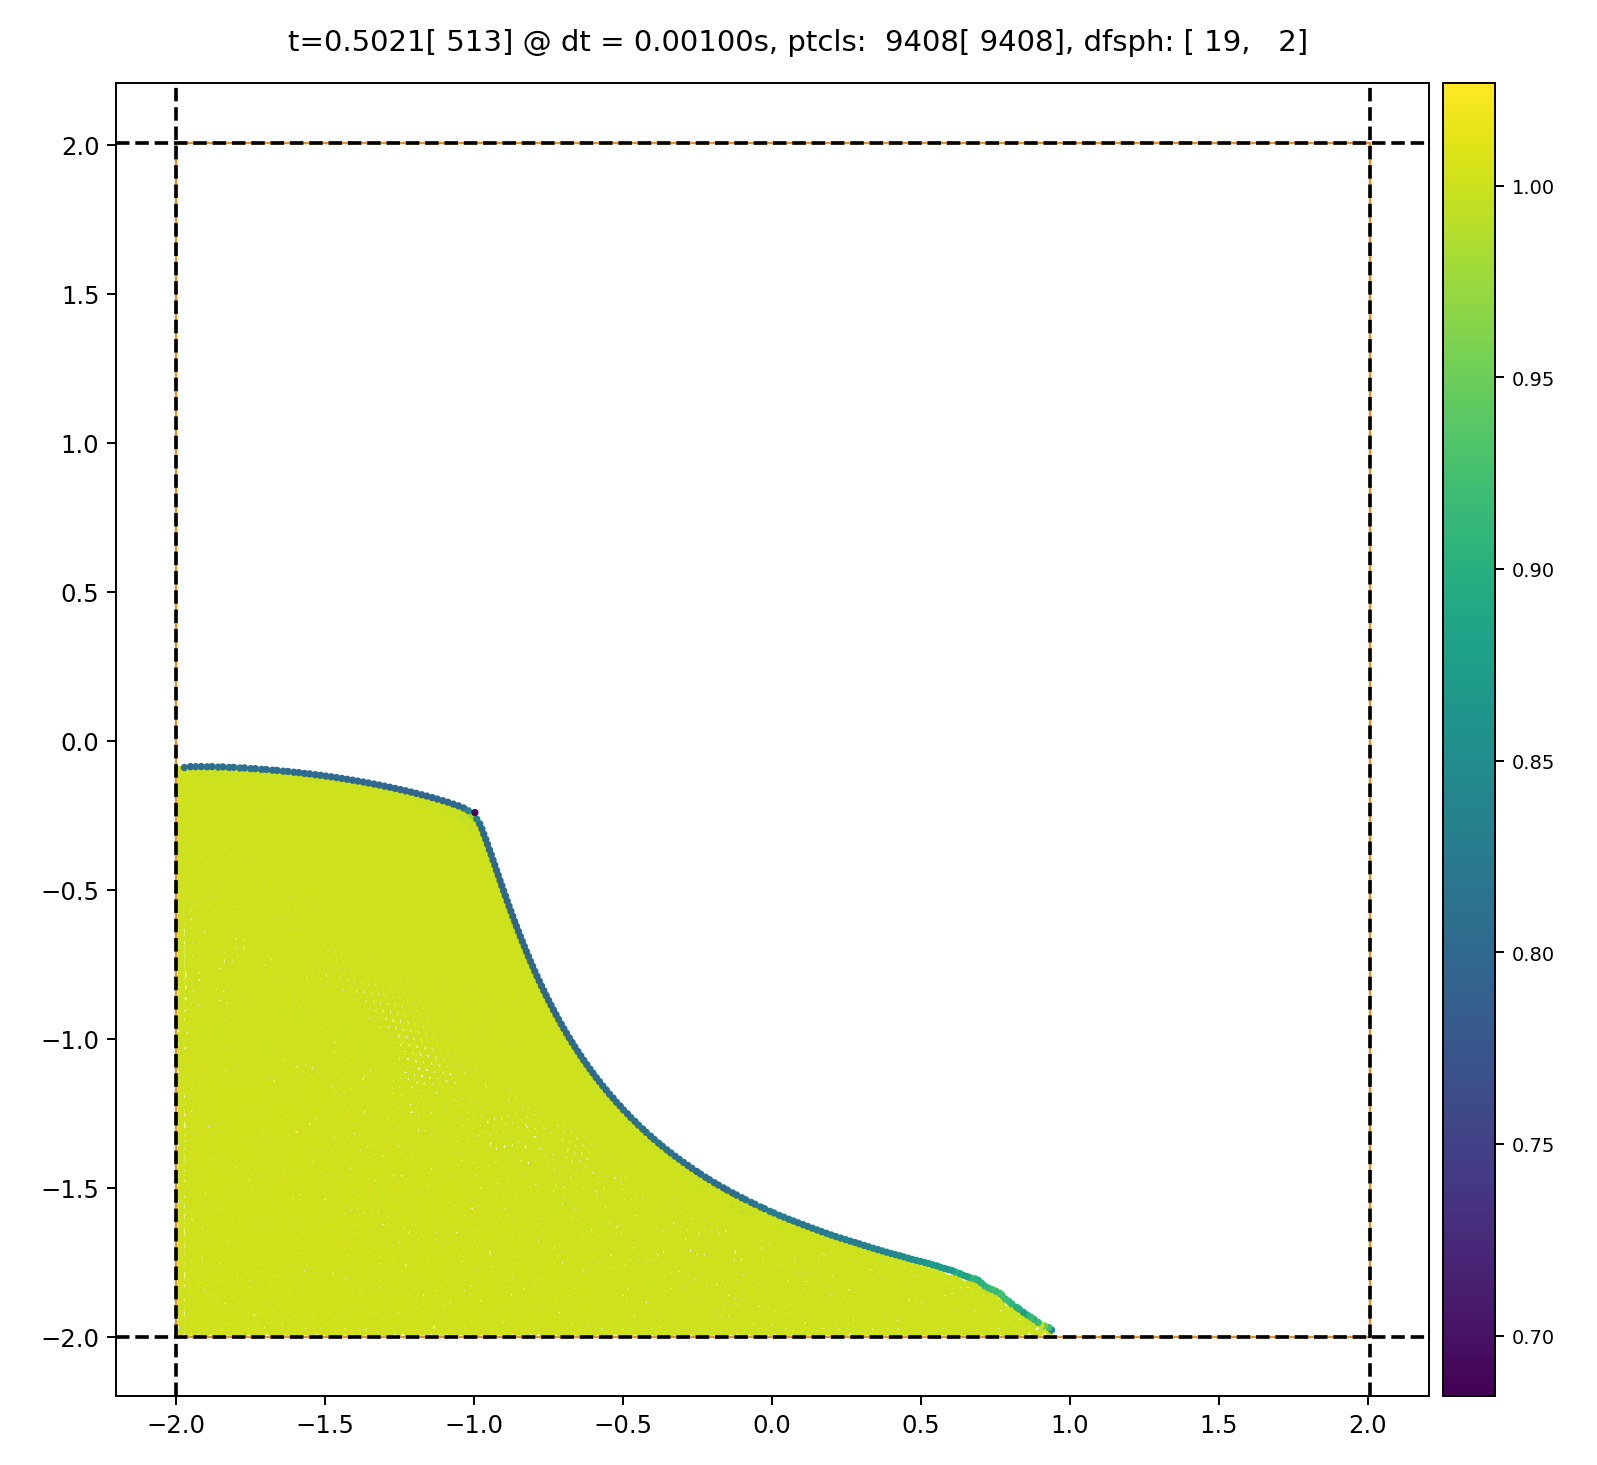

In [14]:

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

fig, axis = sphSimulation.createPlot(plotScale = 2)

state = sphSimulation.simulationState

positions = state['fluidPosition'].detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()


sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [22]:
for i in range(512):
    sphSimulation.timestep()

    
    positions = state['fluidPosition'].detach().cpu().numpy()
#     data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
    data = state['fluidDensity'].detach().cpu().numpy()

    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


    if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
        raise Exception('Simulation borked')

In [32]:


with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.timestep()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.18%       1.732ms        99.98%     957.337ms     957.337ms          -4 b        -268 b    -156.00 Kb    -987.31 Mb             1  
                                        cudaMemcpyAsync        88.47%     847.125ms        88.47%     847.125ms       7.497ms           0 b           0 b           0 b           0 b           113  
         